# 1. Learn Julia: Beyond the basics

## Using examples from epidemic modelling


In this workshop, we will learn some fundamentals of the Julia language beyond the basics: types and how to define them, dispatch, and generic programming.

In my experience, learning programming language concepts is more fun and useful when they are embedded in the context of a particular application. Given the current situation (as of July 2020), **epidemic modelling** provides a key context. We will look at the simplest possible models for epidemics.

We will take as given that you know basic use of variables, functions, `for` loops, and vectors, as well as basic plotting (with the `Plots.jl` library) and vectors in Julia.

We will see various ways to **simulate** the **dynamics** of an **epidemic**, i.e., an outbreak of an infectious disease. In a population of people with $N$ individuals we will be interested in how the number of susceptible ($S$), infectious ($I$) and recovered ($R$) individuals changes over time.


We will begin by looking at simple models that take into account only total numbers of people.
But the main goal will be to see how to structure a more complicated **individual-based** or **agent-based** simulation, where we model individual people moving around space and interacting with one another. 

For simplicity, those individuals will be modelled as **random walks** on a grid, i.e. points that choose a neighbouring grid point at random to jump to.

Since this is a workshop about Julia and not about epidemic modelling *per se*, the models we will use are all very (too) simple. However, once we have the basic ideas and Julia techniques, swapping in a more sophisticated mathematical model becomes much easier.

The models we will study are **stochastic** (or random), i.e. they use probability and random numbers. You only need a basic idea of what it means for something to happen with a given probability, say $p=\frac{1}{4}$: it means that you roll a die with 4 sides and do the action only if, say, the number 4 appears (which has a chance of 1 in 4 of appearing).

## Goal

The main goal is to become comfortable with the use of intermediate-level concepts such as types, multiple dispatch and generic programming, as well as to cover some Julia style tips.

[Comments inside square brackets, like this, are technical side remarks giving more precision about a statement, and should be ignored on a first reading!]

Since this is a workshop, there will be plenty of exercises. You will get much more out of the workshop if you attempt them. I will go over some solutions during the workshop. As usual with programming, there is more than one way to do things though!

We almost certainly will not have enough time to go over all the exercises; you should think of the remainder as being homework exercises.

## Modelling recovery

Let's warm up by thinking about how to model the dynamics of a person recovering from an infection.

Let's start off by supposing that we have 1 person that just got infected. 

We will model the recovery process as follows: at each step, the person recovers **with probability $p$**.
We can think of this as flipping a biased coin: with probability $p$ we get heads, and with probability $1-p$ we get tails. [This is a [**Bernoulli trial**](https://en.wikipedia.org/wiki/Bernoulli_trial).]

Let's write a *function* to model this, since we will call this code many times and functions promote code re-use.

In [15]:
function coin(p)
    r = rand()
    
    return r < p
end

coin (generic function with 1 method)

In [ ]:
"Flip a biased coin with probability \$p\$"
function coin(p)
    r = rand()
    
    return r < p
end

In [34]:
@code_warntype coin(0.3)

Variables
  #self#::Core.Compiler.Const(coin, false)
  p::Float64

Body::Bool
1 ─ %1 = Main.rand()::Float64
│   %2 = (%1 < p)::Bool
└──      return %2


In [3]:
rand

rand (generic function with 69 methods)

In [11]:
rand()   # ctrl-enter

0.4009098217456841

In [12]:
r = rand()

0.05106934264840679

In [13]:
r

0.05106934264840679

In [14]:
typeof(r)

Float64

What is going on here? 

- The first line is a **docstring**, i.e. a string that describes the purpose of the function. If we do `?coin`, we will see this help text. The `$` signs allow us to use LaTeX for equations.


- We are defining a function called `coin`, which takes a parameter `p` and will return `true` or `false`. 

    Functions should be "small" (or preferably tiny) and do a *single thing* that is clear from the name. Usually they will take input data as parameters and return output data that is obtained by calculating using the inputs. They are designed to be **re-usable**.



- We define a local variable `r` as the result of calling the function `rand`. The variable `r` exists only inside the function.


- `rand()` returns a random floating-point number (an approximate real number) that is uniformly distributed in the interval $[0, 1)$.


- In Julia every expression has a value. In this case, `r < p` is a Boolean operator that returns `true` or `false`.


- We return that Boolean value as the return value of the function. It is not necessary to use the keyword `return`; Julia will automatically return the last value calculated in the function.

In [16]:
r

0.05106934264840679

In [17]:
r < 0.3

true

In [28]:
c = coin(1//3)  # // makes a rational number (fraction)

false

In [ ]:
c = coin(1/3)

(You can run the same cell over and over again with `Ctrl-Enter`)

There is an equivalent way to write this using a short-form or "assignment form" function definition:

In [29]:
coin(p) = rand() < p

coin (generic function with 1 method)

In [30]:
coin(1/3)

true

For simple functions like this it is very common to see short-form functions. Just be careful: Don't let them become un-readable because you're trying to squeeze too much into a single line!

In [35]:
v = [1, 2, 3]

3-element Array{Int64,1}:
 1
 2
 3

In [36]:
v = [v; 4]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [37]:
sizehint!(v, 100)

4-element Array{Int64,1}:
 1
 2
 3
 4

## Run many times: Automation

Suppose that we would like to run this function many times. We don't want to do this by hand, of course. Rather we want to **automate** this using a loop.

In [31]:
v = []

0-element Array{Any,1}

In [32]:
v = Int64[]

0-element Array{Int64,1}

In [33]:
push!(v, 1)

1-element Array{Int64,1}:
 1

In [38]:
typeof(true)

Bool

In [39]:
v = Bool[]

0-element Array{Bool,1}

In [40]:
v = [true]

1-element Array{Bool,1}:
 1

In [43]:
b = coin(1/3)

true

In [44]:
Int64(b)

1

In [45]:
Float64(b)

1.0

**Exercise**: 
1. Run `coin` $N=100$ times and store the results in a `Vector`. Can you think of two different ways to do this in Julia?


2. In Julia we should always aim to have useful code inside a **function**. Make a function `coins` that takes as parameters $N$ and $p$ and runs `coin` $N$ times with probability $p$, and returns a vector of the results. 

    Note: It is almost never useful to *print things out* (except possibly when debugging to see what's going wrong inside a function). Instead, *return* the results!


3. Make a function `success_rate` that calculates the proportion of times that recovery was successful. Make sure to *re-use* the work that you have already done!


4. Run `success_rate` 1000 times and store the result in a variable. Make a histogram of the result.


5. Use `Interact.jl` to make an interactive visualization of taking the histogram of different amounts of data from this data set.

In [ ]:
v = Bool[]

for i in 1:100
    

In [46]:
1:10^7  

1:100

In [47]:
typeof(1:100)

UnitRange{Int64}

In [48]:
collect(1:10)

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [55]:
v = Bool[]
p = 0.25

val = for i in 1:100 # type '\in <TAB>`  
    
    c = coin(p)
    push!(v, c)
    
end

In [56]:
val

In [57]:
print(val)

nothing

In [58]:
typeof(val)

Nothing

In [61]:
print(v')   # ' = transpose

Bool[0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]

In [64]:
v = [coin(p) for i in 1:100]

print(v')

Bool[0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

In [66]:
v = zeros(Int, 100)
v'

1×100 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0

In [71]:
for i in 1:100 # type '\in <TAB>`  
    
    c = coin(p)
    v[i] = c  # don't use push! if already allocated!
    
end

In [73]:
coins(N, p) = [coin(p) for i in 1:N]

coins (generic function with 1 method)

In [78]:
num_coins = 100
prob = 0.25

flips = coins(num_coins, prob);

In [79]:
sum(flips)

30

In [80]:
length(flips)

100

In [81]:
total = 0
for i in 1:length(flips)
    total = total + flips[i]
end

In [82]:
total

30

In [84]:
flips'

1×100 LinearAlgebra.Adjoint{Bool,Array{Bool,1}}:
 0  0  0  1  1  0  0  0  1  0  0  0  0  …  0  0  0  1  0  0  1  0  0  0  0  1

In [85]:
flips[3]

false

In [86]:
v = [1, 2, 3]

3-element Array{Int64,1}:
 1
 2
 3

In [87]:
v = 0

0

In [88]:
total = 0
for i in eachindex(flips)
    total = total + flips[i]
end

In [89]:
eachindex(flips)

Base.OneTo(100)

In [90]:
?Base.OneTo

```
Base.OneTo(n)
```

Define an `AbstractUnitRange` that behaves like `1:n`, with the added distinction that the lower limit is guaranteed (by the type system) to be 1.


## Broadcasting

In [93]:
rand(10) < 0.5

10-element Array{Float64,1}:
 0.3801821963025096
 0.6381952466511054
 0.6048582094995107
 0.9247431746905026
 0.6386431847894762
 0.32292353332729395
 0.6301353379924977
 0.29133441316320385
 0.48754928315434176
 0.26112589681827414

In [94]:
rand(1:5, 10)

10-element Array{Int64,1}:
 1
 5
 1
 1
 4
 3
 4
 4
 4
 2

In [95]:
rand(10) < 0.5

MethodError: MethodError: no method matching isless(::Array{Float64,1}, ::Float64)
Closest candidates are:
  isless(!Matched::Float64, ::Float64) at float.jl:465
  isless(!Matched::Missing, ::Any) at missing.jl:87
  isless(!Matched::AbstractFloat, ::AbstractFloat) at operators.jl:156
  ...

In [96]:
rand(10) .< 0.5   # . means "broadcast" -- run the function element by element

10-element BitArray{1}:
 1
 0
 1
 0
 1
 1
 0
 1
 0
 0

`.` means "point" --  pointwise (element-wise) operation

In [98]:
f(x) = 2x

f (generic function with 1 method)

In [99]:
f.(1:10)

10-element Array{Int64,1}:
  2
  4
  6
  8
 10
 12
 14
 16
 18
 20

In [100]:
success_rate(N, p) = sum(coins(N, p)) / N

success_rate (generic function with 1 method)

In [101]:
success_rate(100, 0.25)

0.33

In [102]:
success_rate(100, 0.25)

0.2

In [105]:
N = 100
p = 0.25
num_times = 1000

rates = [success_rate(N, p) for i in 1:num_times];

In [106]:
rates

1000-element Array{Float64,1}:
 0.2
 0.26
 0.3
 0.17
 0.3
 0.3
 0.24
 0.2
 0.26
 0.36
 0.25
 0.17
 0.22
 ⋮
 0.23
 0.23
 0.25
 0.27
 0.3
 0.27
 0.17
 0.24
 0.27
 0.28
 0.28
 0.22

## Plotting

Install Plots package -- only do this once for each Julia installation!

In [ ]:
using Pkg
Pkg.add("Plots")

In [ ]:
] add Plots   # install Plots.jl package

### Load the package in every Julia session:

In [107]:
using Plots  # package called Plots.jl

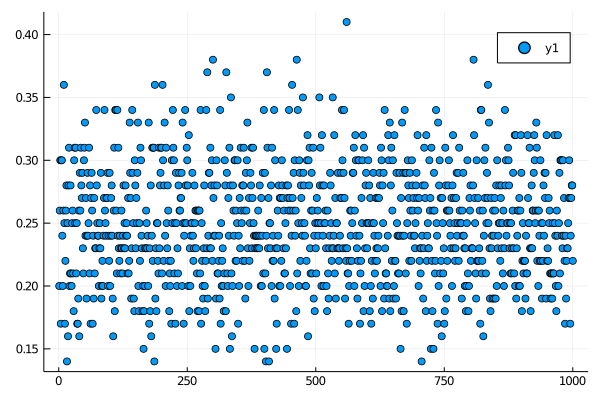

In [109]:
scatter(rates)  # scatter is a function from the Plots.jl package

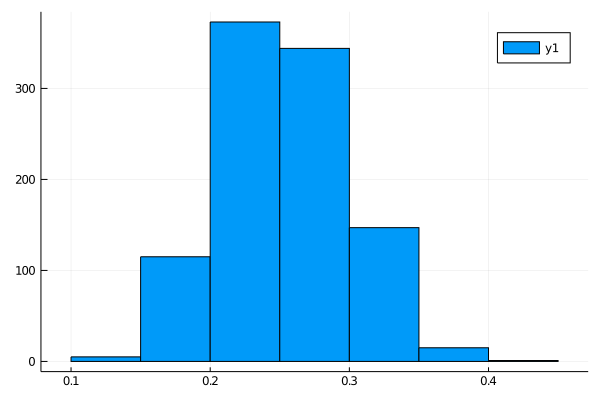

In [114]:
histogram(rates, bins=10, normed=false)

In [115]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3873129822863582168\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-934892865881954942\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3873129822863582168\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [116]:
@manipulate for i in 1:10
    i^2
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dpsanders/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dpsanders/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dpsanders/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/dpsanders/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/dpsanders/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010995e1d0, Task (runnable) @0x000000010995e1d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"5150170613127095506\",\"id\":\"11422148318751916169\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"na

Alternative great solution:

Pluto.jl

In [122]:
rates = [success_rate(N, p) for i in 1:10^5];

In [124]:
@manipulate for n in 1:10000
    histogram(rates[1:n], bins=100, normed=false)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10000,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
5000, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dpsanders/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dpsanders/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dpsanders/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/dpsanders/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/dpsanders/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010a354010, Task (runnable) @0x000000010a354010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\

## Time to recover

Now let's think about a single person and ask "how long does it take for that person to recover?".

#### Exercise:

1. Write a function `recovery_time` that calculates the time it takes *until* the person  recovers.


2. Plot the probability distribution of recovery times.

## Decay pathways

How does the infection "decay"?

#### Exercise

1. Write a function `recovered` that returns a `Vector` of integers that says whether the person is still infected (1) or has recovered (0) at time $t$, for $t$ from 0 to 50.


2. Plot a few runs of the function on a single graph.


3. Find the proportion of the people that have recovered by time $t$ as a function of $t$ and plot it. How does it behave?